## 1. Imports and Load Data

In [1]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    XLMRobertaForSequenceClassification,
    TrainerCallback,
    pipeline
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from datasets import Dataset, DatasetDict
import warnings
import logging
import torch
import torch.nn as nn





c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

train_df = pd.read_csv("../data/cleaned/finetuning-splitstrain_set.csv")
test_df = pd.read_csv("../data/cleaned/finetuning-splitstest_set.csv")

print("=== ORIGINALE Distribution ===")
print("Train set (433):")
print(train_df['label'].value_counts())
print("\nTest set (109):")
print(test_df['label'].value_counts())


=== ORIGINALE Distribution ===
Train set (433):
label
2    300
0     94
1     39
Name: count, dtype: int64

Test set (109):
label
2    75
0    24
1    10
Name: count, dtype: int64


### CALCULATE THE WEIGHTS OF THE CLASSES

In [5]:
print("\n" + "="*60)
print("COMPUTING CLASS WEIGHTS")
print("="*60)

# Compute from actual training data (not from hardcoded counts)
train_labels = train_df['label'].values
classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# Display class distribution and weights
class_counts = train_df['label'].value_counts().sort_index()
for i, (cls, count) in enumerate(class_counts.items()):
    print(f"Class {cls}: {count} samples → Weight: {class_weights[i]:.4f}")

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"\nWeight tensor: {class_weights_tensor}")


COMPUTING CLASS WEIGHTS
Class 0: 94 samples → Weight: 1.5355
Class 1: 39 samples → Weight: 3.7009
Class 2: 300 samples → Weight: 0.4811

Weight tensor: tensor([1.5355, 3.7009, 0.4811])


## 2.Load the XLM-RoBERTa-base tokenizer and tokenise the dataset

In [6]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Analyze the distribution of text lengths

In [7]:
lengths = train_df["text"].apply(lambda x: len(tokenizer.tokenize(x)))
lengths.describe()

count    433.000000
mean      37.441109
std       56.106478
min        1.000000
25%        6.000000
50%       15.000000
75%       48.000000
max      420.000000
Name: text, dtype: float64

### Tokenization function

In [8]:
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=96)

- `truncation=True`  
  - **Purpose:** Cuts texts that are too long so they do not exceed `max_length`.  
  - **Why:** Most models have a maximum input size, and longer texts must be truncated to avoid errors.

- `padding="max_length"`  
  - **Purpose:** Adds `PAD` tokens to make all texts the same length (`max_length`).  
  - **Why:** Models usually require inputs of uniform length within a batch for efficient computation.

- `max_length=128`  
  - **Purpose:** Sets the maximum number of tokens per text.  
  - **Why:** Ensures that all sequences are of consistent length, either truncated or padded, for the model.


### Tokenize the dataset

In [9]:
# Create Datasets
train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["text", "label"]])

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=32)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=32)


Map: 100%|██████████| 109/109 [00:00<00:00, 5476.18 examples/s]


- `batched=True`  
  - **Purpose:** Applies the function **batch-wise** instead of one example at a time.  
  - **How it works:** A small batch (list) of examples is sent to the function, and the function processes the **entire list of texts at once**.  
  - **Why:** This is more efficient for large datasets, as it reduces the overhead of calling the function for each single text.

## 3.Prepare for training

### Formatting for PyTorch

- Remove columns that are no longer needed (e.g., `text`).  
- Convert the remaining columns into PyTorch tensors so that the `Trainer` can directly train the model.


In [10]:
train_ds = Dataset.from_pandas(train_df[["text", "label"]])
test_ds = Dataset.from_pandas(test_df[["text", "label"]])

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# Convertir label → labels (trainer attend "labels")
def prepare_labels(example):
    return {"labels": int(example["label"])}

train_ds = train_ds.map(prepare_labels)
test_ds = test_ds.map(prepare_labels)

# Supprimer colonne "text" (inutile) — et garder input_ids, attention_mask, labels
train_ds = train_ds.remove_columns(["text"])
test_ds = test_ds.remove_columns(["text"])

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 109/109 [00:00<00:00, 8039.16 examples/s]


### metrics calculation

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted'),
        "f1": f1_score(labels, preds, average='weighted'),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "recall_macro": recall_score(labels, preds, average="macro"),
        "recall_class1": recall_score(labels, preds, average=None)[1],  # classe 1
    }


## 4.Charge the model 

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(classes)
)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d03ab607-08e2-4c5a-b749-f093b42d374e)')' thrown while requesting HEAD https://huggingface.co/xlm-roberta-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### INITIALIZING WEIGHTED LOSS MODEL

In [14]:
# Loss pondérée
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)
loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Custom Trainer pour injecter Weighted Loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

### Define the training arguments

In [15]:
training_args = TrainingArguments(
    output_dir="./xlmr_weighted",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20
)

c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 5.Create the trainer and Train the model

In [16]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()


C:\Users\MSI\AppData\Local\Temp\ipykernel_9240\2704862324.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
  7%|▋         | 20/275 [00:59<11:04,  2.61s/it]

{'loss': 1.077, 'grad_norm': 9.601676940917969, 'learning_rate': 1.8545454545454545e-05, 'epoch': 0.36}


 15%|█▍        | 40/275 [02:07<18:15,  4.66s/it]

{'loss': 1.1175, 'grad_norm': 95.04731750488281, 'learning_rate': 1.7090909090909092e-05, 'epoch': 0.73}


 20%|██        | 55/275 [03:09<13:09,  3.59s/it]c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 20%|██        | 55/275 [03:22<13:09,  3.59s/it]

{'eval_loss': 1.0299874544143677, 'eval_accuracy': 0.6788990825688074, 'eval_precision': 0.6366270137395198, 'eval_recall': 0.6788990825688074, 'eval_f1': 0.6549736026681932, 'eval_f1_macro': 0.4286433523101352, 'eval_f1_weighted': 0.6549736026681932, 'eval_recall_macro': 0.4611111111111111, 'eval_recall_class1': 0.0, 'eval_runtime': 12.582, 'eval_samples_per_second': 8.663, 'eval_steps_per_second': 1.113, 'epoch': 1.0}


 22%|██▏       | 60/275 [03:40<14:48,  4.13s/it]

{'loss': 1.0451, 'grad_norm': 11.66496467590332, 'learning_rate': 1.563636363636364e-05, 'epoch': 1.09}


 29%|██▉       | 80/275 [04:37<09:17,  2.86s/it]

{'loss': 0.9567, 'grad_norm': 8.585403442382812, 'learning_rate': 1.4181818181818183e-05, 'epoch': 1.45}


 36%|███▋      | 100/275 [05:35<08:04,  2.77s/it]

{'loss': 1.1294, 'grad_norm': 20.843122482299805, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.82}


 40%|████      | 110/275 [06:01<06:41,  2.44s/it]c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 40%|████      | 110/275 [06:08<06:41,  2.44s/it]

{'eval_loss': 0.9342707395553589, 'eval_accuracy': 0.7981651376146789, 'eval_precision': 0.7218259461742416, 'eval_recall': 0.7981651376146789, 'eval_f1': 0.7494181473705085, 'eval_f1_macro': 0.5067912954578647, 'eval_f1_weighted': 0.7494181473705085, 'eval_recall_macro': 0.5094444444444445, 'eval_recall_class1': 0.0, 'eval_runtime': 6.3373, 'eval_samples_per_second': 17.2, 'eval_steps_per_second': 2.209, 'epoch': 2.0}


 44%|████▎     | 120/275 [06:38<07:13,  2.80s/it]

{'loss': 1.0177, 'grad_norm': 48.234771728515625, 'learning_rate': 1.1272727272727272e-05, 'epoch': 2.18}


 51%|█████     | 140/275 [08:10<08:04,  3.59s/it]

{'loss': 0.9062, 'grad_norm': 11.430763244628906, 'learning_rate': 9.81818181818182e-06, 'epoch': 2.55}


 58%|█████▊    | 160/275 [09:06<05:19,  2.77s/it]

{'loss': 0.8937, 'grad_norm': 30.61676597595215, 'learning_rate': 8.363636363636365e-06, 'epoch': 2.91}


                                                 
 60%|██████    | 165/275 [09:25<04:28,  2.44s/it]

{'eval_loss': 0.8102592825889587, 'eval_accuracy': 0.8532110091743119, 'eval_precision': 0.8630892325019358, 'eval_recall': 0.8532110091743119, 'eval_f1': 0.8217996379962026, 'eval_f1_macro': 0.6242585428755641, 'eval_f1_weighted': 0.8217996379962026, 'eval_recall_macro': 0.6122222222222222, 'eval_recall_class1': 0.1, 'eval_runtime': 5.8413, 'eval_samples_per_second': 18.66, 'eval_steps_per_second': 2.397, 'epoch': 3.0}


 65%|██████▌   | 180/275 [10:12<04:50,  3.06s/it]

{'loss': 0.7799, 'grad_norm': 19.369047164916992, 'learning_rate': 6.90909090909091e-06, 'epoch': 3.27}


 73%|███████▎  | 200/275 [11:07<03:20,  2.68s/it]

{'loss': 0.8009, 'grad_norm': 40.54628372192383, 'learning_rate': 5.4545454545454545e-06, 'epoch': 3.64}


 80%|████████  | 220/275 [12:01<02:11,  2.38s/it]

{'loss': 0.9816, 'grad_norm': 293.83721923828125, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 220/275 [12:06<02:11,  2.38s/it]

{'eval_loss': 0.8995541930198669, 'eval_accuracy': 0.8256880733944955, 'eval_precision': 0.8413183826027862, 'eval_recall': 0.8256880733944955, 'eval_f1': 0.7982406152940422, 'eval_f1_macro': 0.6081173728232552, 'eval_f1_weighted': 0.7982406152940422, 'eval_recall_macro': 0.6083333333333333, 'eval_recall_class1': 0.1, 'eval_runtime': 5.8561, 'eval_samples_per_second': 18.613, 'eval_steps_per_second': 2.391, 'epoch': 4.0}


 87%|████████▋ | 240/275 [13:04<01:30,  2.58s/it]

{'loss': 0.6691, 'grad_norm': 11.00602912902832, 'learning_rate': 2.5454545454545456e-06, 'epoch': 4.36}


 95%|█████████▍| 260/275 [14:02<00:52,  3.49s/it]

{'loss': 0.6648, 'grad_norm': 21.929180145263672, 'learning_rate': 1.090909090909091e-06, 'epoch': 4.73}


                                                 
100%|██████████| 275/275 [15:10<00:00,  3.44s/it]

{'eval_loss': 0.9894641041755676, 'eval_accuracy': 0.8440366972477065, 'eval_precision': 0.8564724653323634, 'eval_recall': 0.8440366972477065, 'eval_f1': 0.8139673131865207, 'eval_f1_macro': 0.6301096067053514, 'eval_f1_weighted': 0.8139673131865207, 'eval_recall_macro': 0.6172222222222222, 'eval_recall_class1': 0.1, 'eval_runtime': 6.0383, 'eval_samples_per_second': 18.051, 'eval_steps_per_second': 2.319, 'epoch': 5.0}


100%|██████████| 275/275 [15:14<00:00,  3.32s/it]

{'train_runtime': 914.3558, 'train_samples_per_second': 2.368, 'train_steps_per_second': 0.301, 'train_loss': 0.9322246239402078, 'epoch': 5.0}


TrainOutput(global_step=275, training_loss=0.9322246239402078, metrics={'train_runtime': 914.3558, 'train_samples_per_second': 2.368, 'train_steps_per_second': 0.301, 'total_flos': 106807603008960.0, 'train_loss': 0.9322246239402078, 'epoch': 5.0})

In [17]:
metrics = trainer.evaluate(eval_dataset=test_ds)
print("Evaluation metrics on test set:")
print(metrics)


100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

Evaluation metrics on test set:
{'eval_loss': 0.9894641041755676, 'eval_accuracy': 0.8440366972477065, 'eval_precision': 0.8564724653323634, 'eval_recall': 0.8440366972477065, 'eval_f1': 0.8139673131865207, 'eval_f1_macro': 0.6301096067053514, 'eval_f1_weighted': 0.8139673131865207, 'eval_recall_macro': 0.6172222222222222, 'eval_recall_class1': 0.1, 'eval_runtime': 5.9326, 'eval_samples_per_second': 18.373, 'eval_steps_per_second': 2.36, 'epoch': 5.0}


In [18]:
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
target_names = ['negatif', 'neutre', 'positif']

report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# per_class recall et f1
per_class_recall = {cls: report[cls]['recall'] for cls in target_names}
per_class_f1 = {cls: report[cls]['f1-score'] for cls in target_names}

print("Per-class recall:", per_class_recall)
print("Per-class F1:", per_class_f1)


100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

Per-class recall: {'negatif': 0.7916666666666666, 'neutre': 0.1, 'positif': 0.96}
Per-class F1: {'negatif': 0.8085106382978724, 'neutre': 0.18181818181818182, 'positif': 0.8999999999999999}


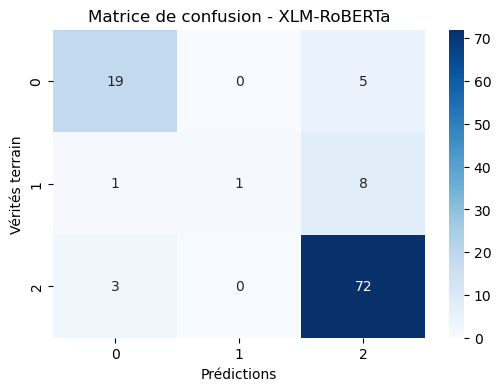

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# matrice brute
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - XLM-RoBERTa")
plt.show()


### Save metrics

In [ ]:
import json
from sklearn.metrics import classification_report


results_json = {
    "model_info": {
        "model_name": model_name,   
        "train_samples": len(train_df),
        "test_samples": len(test_df),
        "class_distribution": {
            "0_Négatif": (train_df['label'] == 0).sum(),
            "1_Neutre": (train_df['label'] == 1).sum(),
            "2_Positif": (train_df['label'] == 2).sum(),
        },
    },
    "transformer_model": {
        "accuracy": metrics.get("eval_accuracy"),
        "precision": metrics.get("eval_precision"),
        "recall": metrics.get("eval_recall"),
        "f1_weighted": metrics.get("eval_f1_weighted"),
        "f1_macro": metrics.get("eval_f1_macro"),
        
    }
}

predictions = trainer.predict(test_ds)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

report = classification_report(
    y_true, 
    y_pred, 
    target_names=["negatif", "neutre", "positif"],
    output_dict=True
)

results_json["classification_report"] = report

def to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    return obj

with open("../finetuning_models/evaluation_finetuning.json", "w", encoding="utf-8") as f:
    json.dump(results_json, f, indent=4, ensure_ascii=False, default=to_serializable)

print("file saved: evaluation_finetuning.json")

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

file saved: evaluation_finetuning.json


### Save the model

In [25]:
trainer.save_model("./my_sentiment_model_without_augmentation")
tokenizer.save_pretrained("./my_sentiment_model_without_augmentation")

('./my_sentiment_model_without_augmentation\\tokenizer_config.json',
 './my_sentiment_model_without_augmentation\\special_tokens_map.json',
 './my_sentiment_model_without_augmentation\\tokenizer.json')

### Load the model and test

In [26]:


model_path = "./my_sentiment_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # important


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [27]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class


In [28]:
predict("je ne connait pas cette salle mais quelqu'un m'a recommandé.")


2